# Coding Assignment 3

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import matplotlib.pyplot as plt

# Data

In [2]:
# Load the dataset
(dataset_train, dataset_test), dataset_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteRXIPB6/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteRXIPB6/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


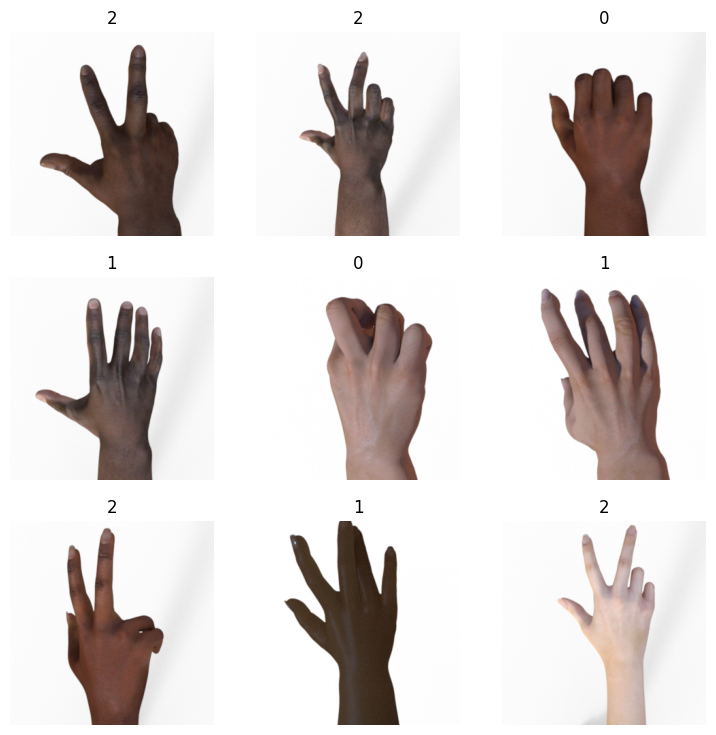

In [3]:
# visualize 9 images.
### No EDITS needed in this code block if previous block ran ###

plt.figure(figsize=(9, 9))
for i, (image, label) in enumerate(dataset_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(int(label))
    plt.axis("off")

# MLP

First develop an MLP model. Since the images are represented by 2D matrices, it will be necessary to reshape each image to
a 1D array (so, overall, the dataset is of shape (len(data), 300*300). But we want to reduce the complexity, especially since the MLP is not ideal for this and we are generating a large, 1D array when flattening.

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir=PosixGPath('/tmp/tmpuk3mfl3otfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [5]:
### No EDITS needed in this code block if previous block ran. This is educational ###

def preprocess_and_flatten(image, label):
    image = tf.image.resize(image, [150, 150])
    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)
    # Normalize the image
    image = tf.cast(image, tf.float32) / 255.0
    # Flatten the image to a 1D tensor
    image = tf.reshape(image, [-1])
    return image, label

# Apply the preprocessing function to the dataset
mlp_train = dataset_train.map(preprocess_and_flatten)
mlp_test = dataset_test.map(preprocess_and_flatten)

# Batch and prefetch the dataset for optimal performance. The prefetch is relevent when working with lage datasets
# as expensive processing hardware must be used to perform the matrix operations and should be used optimally. GPUs or TPUs
# should not run idle once the training has begun. The method for retreiving the data, then, becomes very important
# and this consideration is less relevant with the smaller datasets we have worked with at this point.But I wanted to
# show that this is essential in the real world of big data, and here we're creating a scenario that's artificially making
# the data bigger and suboptimal for demonstration. We will balance this out a bit with the following code:

# use this data for the mlp #
BATCH_SIZE = 32
mlp_train = mlp_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
mlp_test = mlp_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build an MLP Model that Computes an Appropriate Performance Metric

In [17]:
tf.keras.backend.clear_session()

In [18]:
tf.keras.utils.set_random_seed(42)

In [19]:
from tensorflow.keras.metrics import AUC

model_mlp = keras.models.Sequential([

    keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer='he_normal', input_shape=(22500,)),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2), kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(3,activation='softmax')
])




    ### EDIT Needed, add layers including a suitable output layer, given the number of classes (e.g. 3)
    ### EDIT Needed

model_mlp.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               11520512  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 11784707 (44.96 MB)
Trainable params: 11784707 (44.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history = model_mlp.fit(
    mlp_train,
    epochs=15,  # You can adjust the number of epochs
    validation_data=mlp_test
)

Epoch 1/15
79/79 [==============================] - 3s 27ms/step - loss: 16.6756 - accuracy: 0.4071 - val_loss: 5.4816 - val_accuracy: 0.4247
Epoch 2/15
79/79 [==============================] - 2s 21ms/step - loss: 3.8105 - accuracy: 0.4980 - val_loss: 1.1388 - val_accuracy: 0.5914
Epoch 3/15
79/79 [==============================] - 2s 21ms/step - loss: 2.2386 - accuracy: 0.5925 - val_loss: 1.1125 - val_accuracy: 0.7151
Epoch 4/15
79/79 [==============================] - 2s 21ms/step - loss: 1.7973 - accuracy: 0.6675 - val_loss: 2.9959 - val_accuracy: 0.5565
Epoch 5/15
79/79 [==============================] - 2s 21ms/step - loss: 1.6751 - accuracy: 0.6984 - val_loss: 2.5853 - val_accuracy: 0.4194
Epoch 6/15
79/79 [==============================] - 3s 33ms/step - loss: 1.3598 - accuracy: 0.7286 - val_loss: 3.0834 - val_accuracy: 0.5403
Epoch 7/15
79/79 [==============================] - 2s 22ms/step - loss: 0.9805 - accuracy: 0.7873 - val_loss: 2.7240 - val_accuracy: 0.6344
Epoch 8/15
7

### Plot Training/Validation Performance Curves and Describe Result

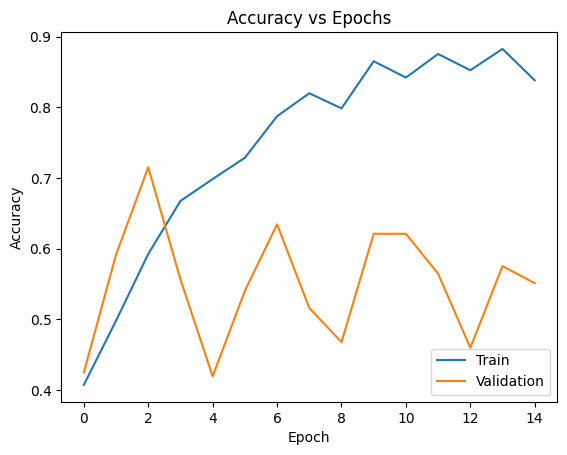

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Description:







In [24]:
#!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [25]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=64, max_value=1024)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-1,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()

    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu")),
        keras.layers.Dropout(rate=0.3)
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [26]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=10, overwrite=True,
    directory="rock_paper_scissors", project_name="my_rnd_search", seed=42)
random_search_tuner.search(mlp_train, epochs=15,
                           validation_data=mlp_test)

Trial 10 Complete [00h 00m 38s]
val_accuracy: 0.7123655676841736

Best val_accuracy So Far: 0.7204301357269287
Total elapsed time: 00h 06m 32s


In [27]:

best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 01 summary
Hyperparameters:
n_hidden: 4
n_neurons: 402
learning_rate: 0.00155822911114866
optimizer: sgd
Score: 0.7204301357269287


# Build a CNN Model that Computes an Appropiate Performance Metric

Now, see if using image specific layers,for instance, the Conv2D, improve the classification performance

In [77]:
tf.keras.backend.clear_session()

In [78]:
# Basic preprocessing: Resize images and normalize
def preprocess(image, label):
    resized_image =  tf.image.resize(image, [150,150])
    #Normalize the pixel intensity values
    return tf.keras.layers.Rescaling(scale=1./255.0)(resized_image), label
    # Note on rescaling: pixel intensities range from 1-255
    #"Rescaling(?? EDIT needed)" is expecting a scaling factor, 1 / ??

# Apply preprocessing to dataset
# use this data for the section where you build a CNN model
BATCH_SIZE = 32
cnn_train = dataset_train.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
cnn_test = dataset_test.map(preprocess).batch(BATCH_SIZE)

In [79]:
from tensorflow.keras import layers, models

# Define the CNN model
cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=(3, 3), input_shape=(150, 150, 3)),
    keras.layers.LeakyReLU(0.1),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3)),
    keras.layers.LeakyReLU(0.1),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3)),
    keras.layers.LeakyReLU(0.1),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    #keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(512),
    keras.layers.Dropout(rate=0.3),
    keras.layers.LeakyReLU(0.1),
    keras.layers.Dense(3, activation='softmax')
])
    # . . . EDITS Needed (for example, add layers, make an output layer with the number of classes, e.g. 3)



# Compile the model
cnn_model.compile(optimizer='adam',
              # the true labels are not one-hot-encoded tensors (0, 0, 1) but integers so we use "sparse"
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 16)      1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 146, 146, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 144, 32)      4640      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 144, 144, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0

In [80]:
cnn_history = cnn_model.fit(
    cnn_train,
    epochs=5,  # You can adjust the number of epochs, keep low unless you have a compute cluster (AWS, Colab Pro)
    validation_data=cnn_test
)

Epoch 1/5
79/79 [==============================] - 23s 82ms/step - loss: 2.7382 - accuracy: 0.8286 - val_loss: 0.7848 - val_accuracy: 0.7500
Epoch 2/5
79/79 [==============================] - 5s 55ms/step - loss: 0.0142 - accuracy: 0.9976 - val_loss: 0.9705 - val_accuracy: 0.7446
Epoch 3/5
79/79 [==============================] - 5s 55ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 1.2384 - val_accuracy: 0.7070
Epoch 4/5
79/79 [==============================] - 5s 53ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.1494 - val_accuracy: 0.7500
Epoch 5/5
79/79 [==============================] - 5s 53ms/step - loss: 3.6255e-04 - accuracy: 1.0000 - val_loss: 1.1802 - val_accuracy: 0.7581


### Plot Training/Validation Performance Curves and Describe Result

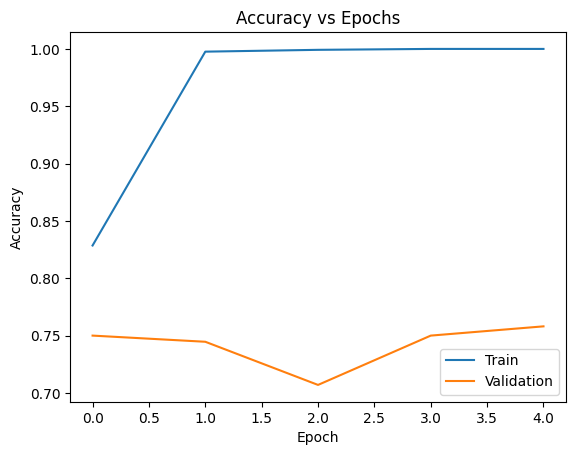

In [81]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Description:




